# Regression with Abalone Dataset

#### Description of dataset
The dataset for this competition (both train and test) was generated from a deep learning model trained on the `Abalone` dataset. Feature distributions are close to, but not exactly the same, as the original. Feel free to use the original dataset as part of this competition, both to explore differences as well as to see whether incorporating the original in training improves model performance.

#### Importer les librairies

In [102]:
# librairie essentielle pour un Data Scientist
import pandas as pd
import numpy as np
import seaborn as sns

# librairie pour le preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# librairie pour la modélisation
from sklearn.model_selection import cross_val_score # split into two sample : validation and training
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor # RandomForest Classifier
from sklearn.svm import SVR # SVR
from sklearn.neighbors import KNeighborsRegressor # KNN
from sklearn.tree import DecisionTreeRegressor # Tree Decision
from sklearn.ensemble import IsolationForest # IsolationForest

# librairie pour la décomposition
from sklearn.decomposition import PCA

# librairie pour la métrique
from sklearn.metrics import make_scorer

# librairie pour optimiser les hyperparamètres
import optuna

# librairie pour les visualisations
import matplotlib.pyplot as plt  

# librairie pour faire de l'industrialisation
import joblib

#### Importer les dataframes

In [103]:
# train data
train_data = pd.read_csv("train.csv")

# test data
test_data = pd.read_csv("test.csv")

# submission set
submission = pd.read_csv("sample_submission.csv")

In [104]:
print(f"Ce dataframe contient {train_data.shape[0]} observations et {train_data.shape[1]} variables.")

Ce dataframe contient 90615 observations et 10 variables.


In [105]:
print(f"Les colonnes sont : {[train_data.columns[i] for i in range(len(train_data.columns))]}")

Les colonnes sont : ['id', 'Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight', 'Rings']


In [106]:
# Identifier les types de chaque colonnes 
train_data.dtypes

id                  int64
Sex                object
Length            float64
Diameter          float64
Height            float64
Whole weight      float64
Whole weight.1    float64
Whole weight.2    float64
Shell weight      float64
Rings               int64
dtype: object

In [107]:
# Suppression de la variable 'identifiant'

train_data = train_data.drop(['id'], axis=1)
test_data = test_data.drop(['id'], axis=1)

#### Nettoyage de la base de données

##### Vérification de la présence de doublons

In [108]:
# Duplicated 

## Recherche des éventuelles duplicated
duplicates = train_data[train_data.duplicated()]
print("Doublons :")
print(duplicates)

## Suppression des duplicated
train_data = train_data.drop_duplicates(keep='first')

Doublons :
Empty DataFrame
Columns: [Sex, Length, Diameter, Height, Whole weight, Whole weight.1, Whole weight.2, Shell weight, Rings]
Index: []


##### Traitement des valeurs manquantes

In [109]:
## Recherche d'éventuel valeurs manquantes selon les colonnes
missing_values = train_data.isnull().sum()
print("Valeurs manquantes :")
print(missing_values) # Aucune valeur manquante

Valeurs manquantes :
Sex               0
Length            0
Diameter          0
Height            0
Whole weight      0
Whole weight.1    0
Whole weight.2    0
Shell weight      0
Rings             0
dtype: int64


##### Traitement des valeurs aberrantes

In [110]:
def outlier_search(dataframe, feature:list):
    
    Q1 = dataframe.drop(feature, axis=1).quantile(0.25) # 1er quartile 
    Q3 = dataframe.drop(feature, axis=1).quantile(0.75) # 3eme quartile
    
    IQR = Q3 - Q1 # écart interquartile
    
    # recherche des outliers dans le dataframe
    outlier = ((dataframe.drop(feature, axis=1) < (Q1 - 1.5 * IQR)) | (dataframe.drop(feature, axis=1) > (Q3 + 1.5 * IQR))).any(axis=1) 
    
    return dataframe.drop(feature, axis=1)[outlier]

In [111]:
outlier_search(train_data, ['Sex', 'Rings'])

,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight
2,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050
8,0.205,0.150,0.040,0.0460,0.0145,0.0105,0.0100
28,0.180,0.110,0.040,0.0315,0.0105,0.0065,0.0050
36,0.180,0.125,0.040,0.0275,0.0110,0.0095,0.0080
62,0.725,0.565,0.205,1.9260,0.9590,0.3800,0.4400
...,...,...,...,...,...,...,...
90513,0.710,0.550,0.195,2.0045,1.0115,0.4255,0.5015
90531,0.720,0.550,0.220,2.1730,1.0815,0.4665,0.5780
90536,0.740,0.595,0.195,2.5500,1.1965,0.5655,0.6200
90578,0.760,0.575,0.205,2.0150,0.8010,0.4800,0.5000


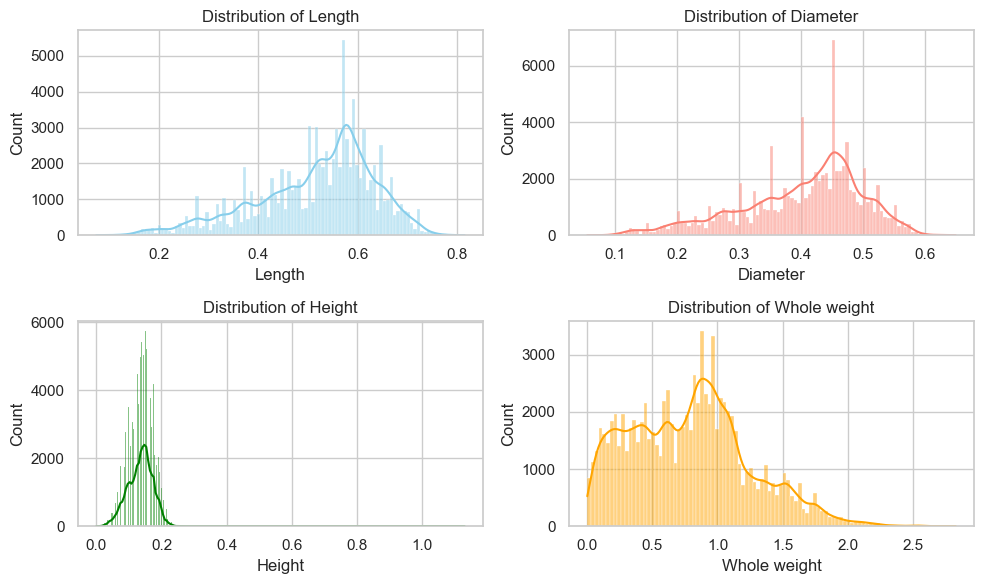

In [112]:
# Vérifier si ces valeurs aberrantes sont intéressantes dans le cadre de notre étude
# Définir le style de seaborn
sns.set(style="whitegrid")

# Tracer les diagrammes de distribution pour chaque variable
plt.figure(figsize=(10, 6))

# Length
plt.subplot(2, 2, 1)
sns.histplot(data=train_data, x='Length', kde=True, color='skyblue')
plt.title('Distribution of Length')

# Diameter
plt.subplot(2, 2, 2)
sns.histplot(data=train_data, x='Diameter', kde=True, color='salmon')
plt.title('Distribution of Diameter')

# Height
plt.subplot(2, 2, 3)
sns.histplot(data=train_data, x='Height', kde=True, color='green')
plt.title('Distribution of Height')

# Whole weight
plt.subplot(2, 2, 4)
sns.histplot(data=train_data, x='Whole weight', kde=True, color='orange')
plt.title('Distribution of Whole weight')

plt.tight_layout()
plt.show()

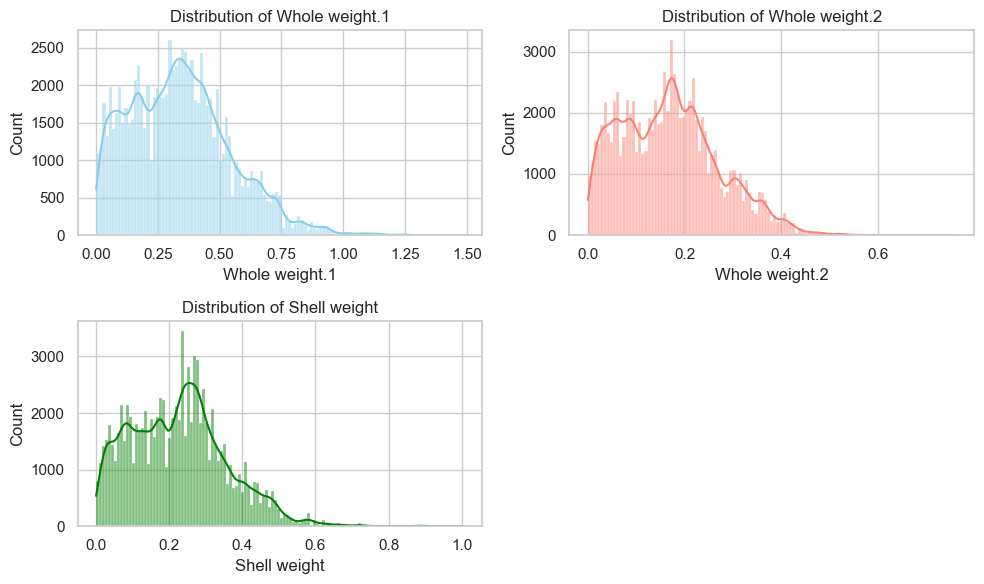

In [113]:
# Vérifier si ces valeurs aberrantes sont intéressantes dans le cadre de notre étude
# Définir le style de seaborn
sns.set(style="whitegrid")

# Tracer les diagrammes de distribution pour chaque variable
plt.figure(figsize=(10, 6))

# Whole weight.1
plt.subplot(2, 2, 1)
sns.histplot(data=train_data, x='Whole weight.1', kde=True, color='skyblue')
plt.title('Distribution of Whole weight.1')

# Whole weight.2
plt.subplot(2, 2, 2)
sns.histplot(data=train_data, x='Whole weight.2', kde=True, color='salmon')
plt.title('Distribution of Whole weight.2')

# Shell weight
plt.subplot(2, 2, 3)
sns.histplot(data=train_data, x='Shell weight', kde=True, color='green')
plt.title('Distribution of Shell weight')

plt.tight_layout()
plt.show()

Les récentes études faites ne nous permettent de conclure efficacement sur les valeurs aberrantes. 

Nous utiliserons alors le modèle `IsolationForest` pour détecter les anomalies.

In [114]:
# Méthode pour détecter les anomalies 
model = IsolationForest(n_estimators=100,max_samples='auto',contamination=0.1) # modèle de détection des données

model.fit(train_data.drop(['Sex', 'Rings'], axis=1)) # entraînement du modèle

copy_train_data = train_data.copy()

copy_train_data['scores'] = model.decision_function(train_data.drop(['Sex', 'Rings'], axis=1))

copy_train_data['anomaly'] = model.predict(train_data.drop(['Sex', 'Rings'], axis=1))

In [115]:
# Supprimer les observations de la base de données initiale où 'anomaly' est égal à -1
data_without_anomalies = copy_train_data.drop(copy_train_data[copy_train_data['anomaly'] == -1].index)

In [116]:
# Supprimer les scores et les anomalies
data_without_anomalies = data_without_anomalies.drop(['scores', 'anomaly'], axis=1)

#### Analyse descriptive

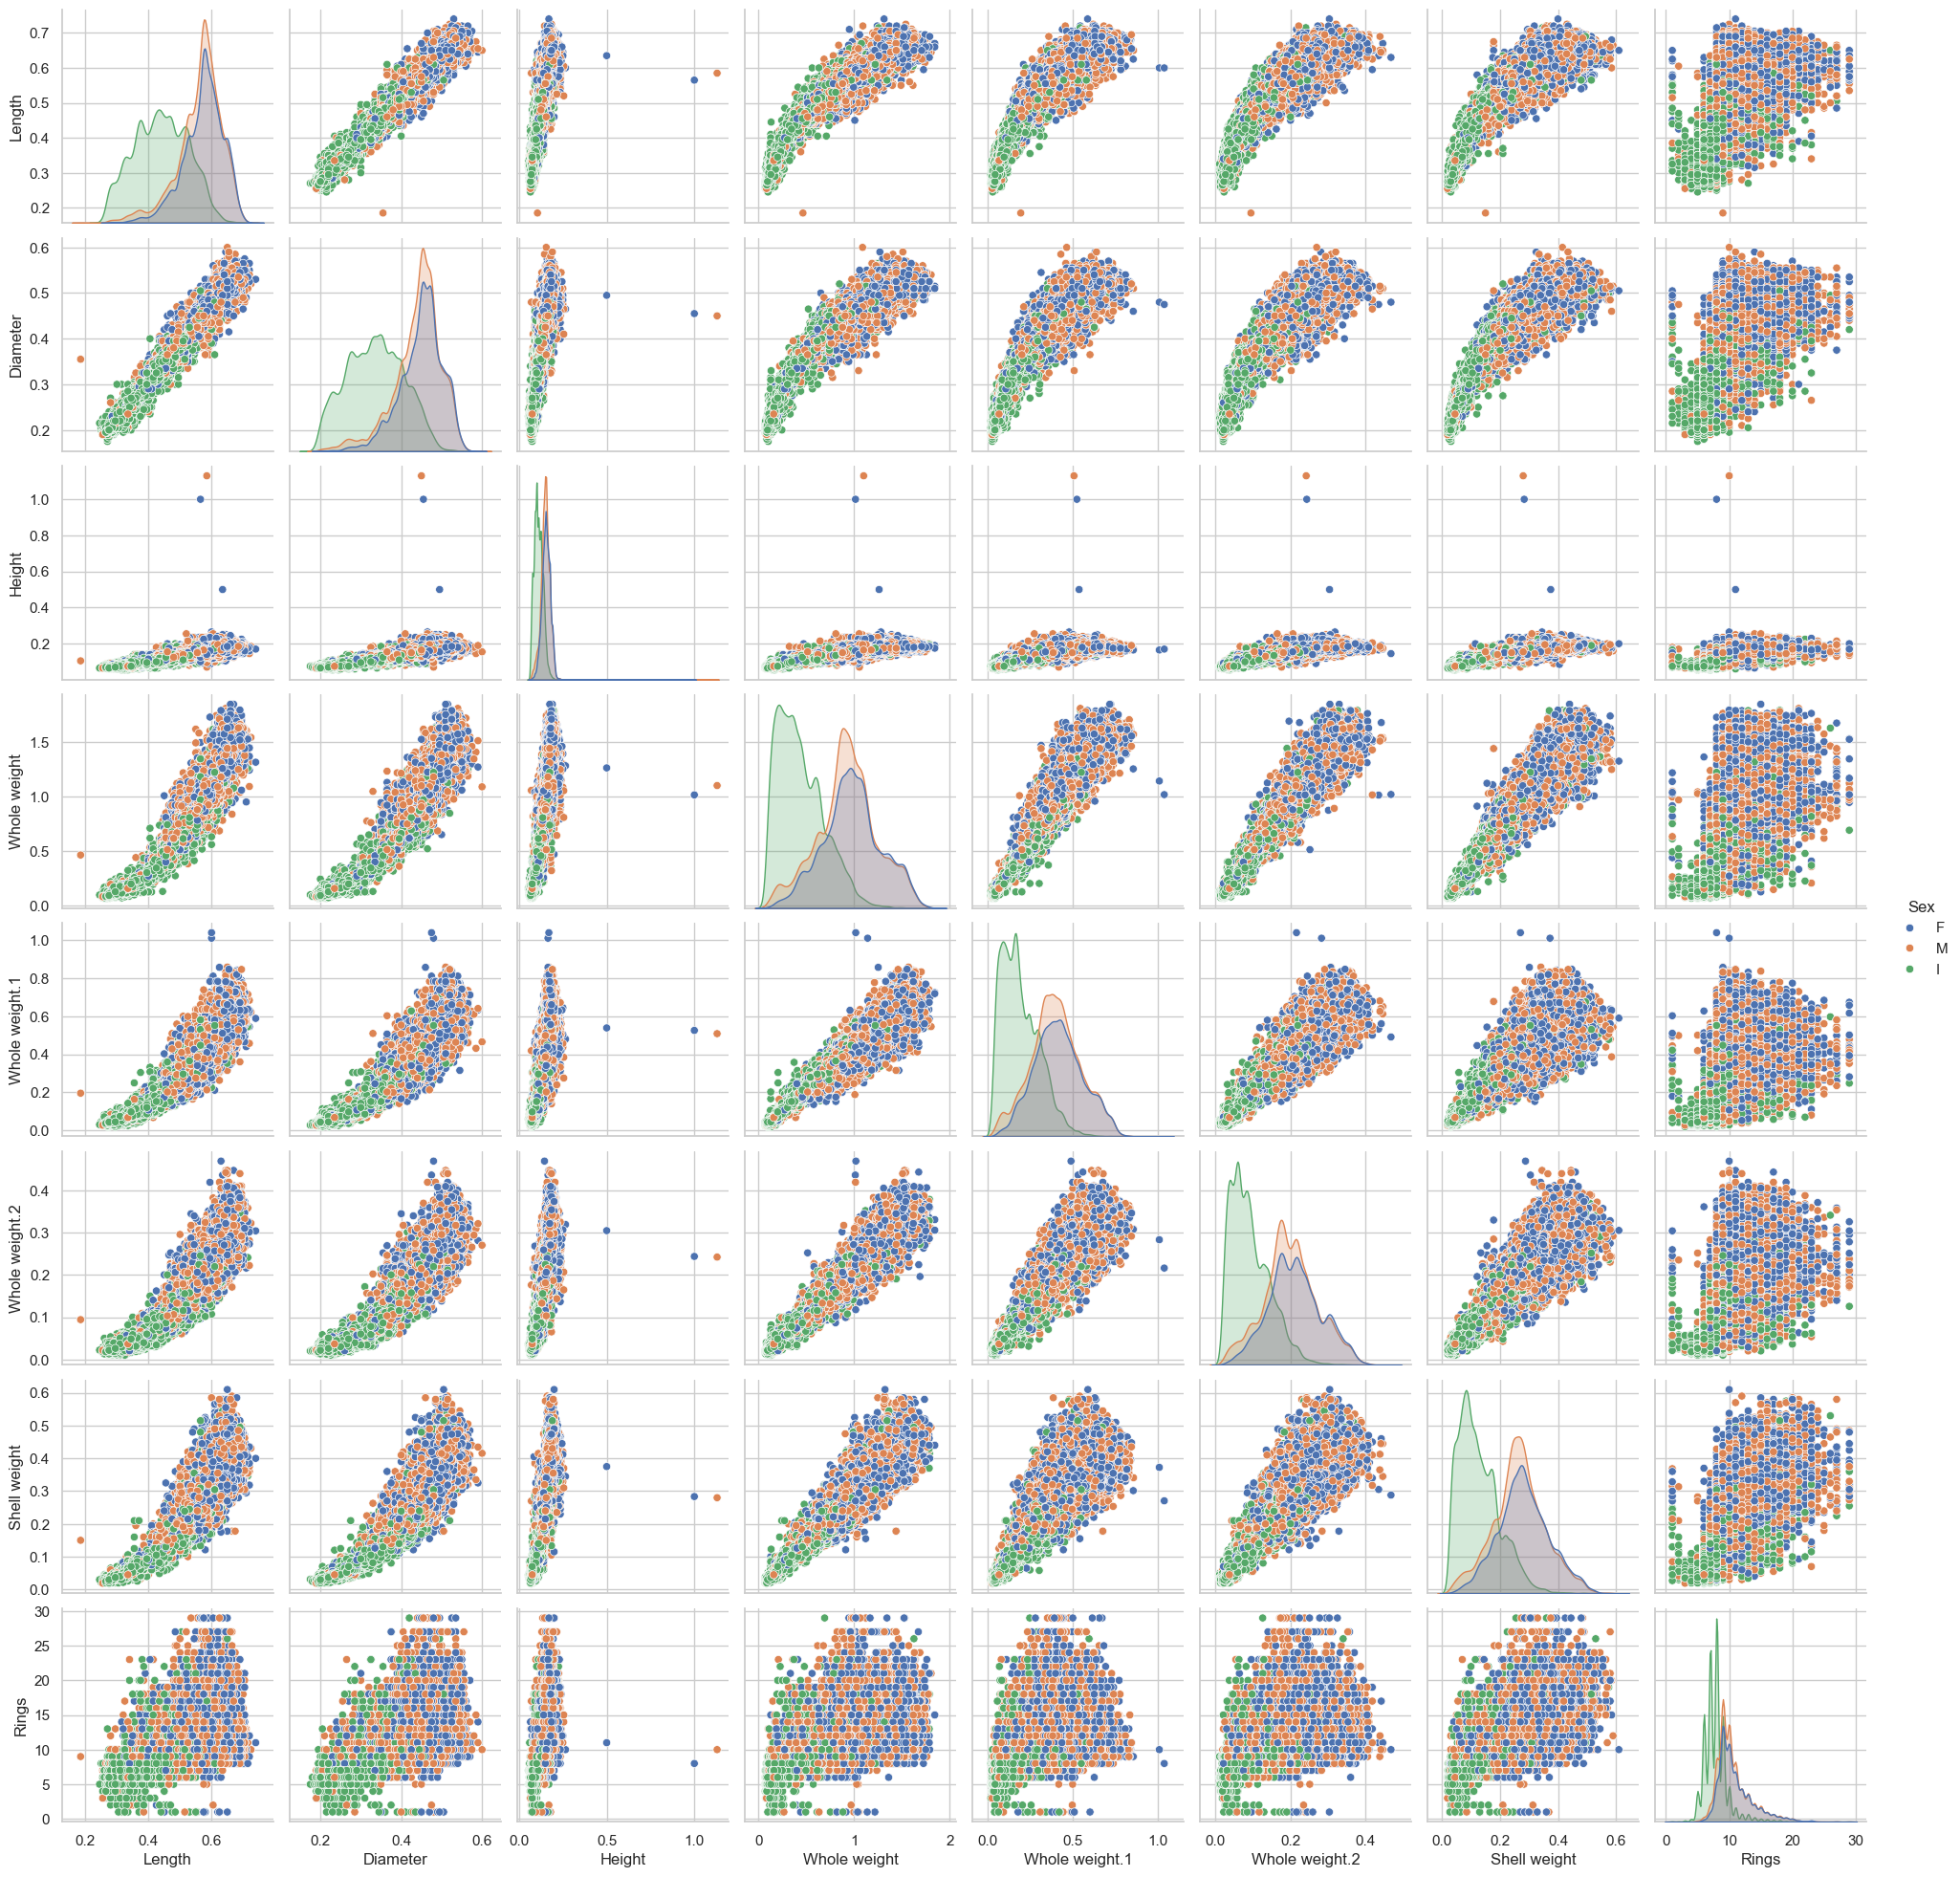

In [117]:
sns.pairplot(data_without_anomalies, hue='Sex')

Globalement, on constate une forte corrélation entre les features. Il faudra procéder à des sélections de variables.

In [118]:
# Mettre la variable "Sex" en catégorielle
data_without_anomalies['Sex'] = data_without_anomalies['Sex'].astype('category')

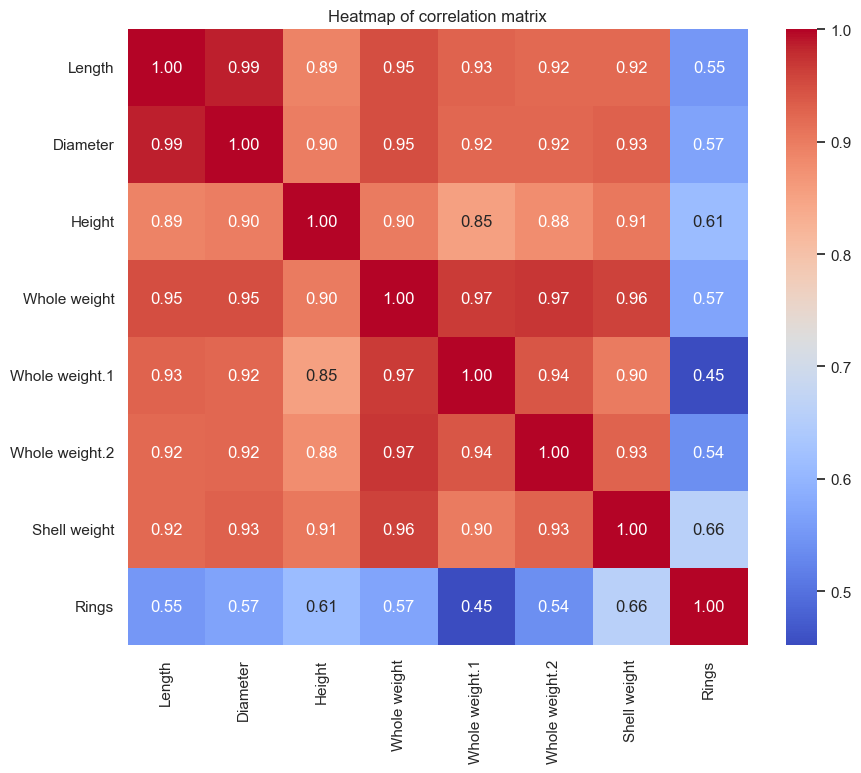

In [119]:
# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(data_without_anomalies.drop(["Sex"], axis=1).corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap of correlation matrix')
plt.show()

À l'aide du heatmap, on observe que les variables `Height` et `Shell weight` sont corrélées avec la variable cible `Rings`.

In [120]:
# Analyse descriptive des variables quantitatives (moyenne, écart-type, minimum, maximum)
data_without_anomalies.describe()

,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
count,81553.000000,81553.000000,81553.000000,81553.000000,81553.000000,81553.000000,81553.000000,81553.000000
mean,0.520608,0.404428,0.135857,0.765134,0.330060,0.164667,0.219880,9.745773
std,0.096521,0.080692,0.031823,0.379235,0.169161,0.085373,0.108905,2.948981
min,0.185000,0.175000,0.055000,0.068500,0.020000,0.010500,0.018000,1.000000
25%,0.455000,0.350000,0.115000,0.447000,0.189500,0.093000,0.130000,8.000000
50%,0.540000,0.425000,0.140000,0.790500,0.328500,0.164500,0.225000,9.000000
75%,0.590000,0.465000,0.160000,1.029500,0.445500,0.222000,0.295000,11.000000
max,0.740000,0.600000,1.130000,1.844000,1.038500,0.469500,0.610000,29.000000


In [121]:
# Calcul de la valeur moyenne de 'Rings' en fonction du sexe
data_without_anomalies[['Sex', 'Rings']].groupby(['Sex'], as_index=False).mean().sort_values(by='Rings', ascending=False)

/var/folders/xx/01dz8x2j0c58d1hmyyx2c3b80000gn/T/ipykernel_1296/113977997.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data_without_anomalies[['Sex', 'Rings']].groupby(['Sex'], as_index=False).mean().sort_values(by='Rings', ascending=False)


,Sex,Rings
0,F,10.978491
2,M,10.639261
1,I,7.874915


In [122]:
# Répartition des sexes
data_without_anomalies[['Sex', 'Rings']].groupby(['Sex'], as_index=False).count().sort_values(by='Rings', ascending=False)

/var/folders/xx/01dz8x2j0c58d1hmyyx2c3b80000gn/T/ipykernel_1296/3765676632.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data_without_anomalies[['Sex', 'Rings']].groupby(['Sex'], as_index=False).count().sort_values(by='Rings', ascending=False)


,Sex,Rings
1,I,29292
2,M,28364
0,F,23897


Dans l'ensemble, la répartition est équilibrée et on trouve des valeurs plus élevées pour les sexes masculin et féminin. 

#### Modélisation statistiques
Pour modéliser, nous utiliserons différents approches de sélection de variables : 
- suppression des features corrélées : se concentrer uniquement sur les variables corrélées avec la variable cible;
- réduction des dimensions;
- technique de régularisations : utiliser les techniques de Lasso et Elasticnet.

In [123]:
# Définissons la variable cible
y = data_without_anomalies['Rings']

In [124]:
# Définissons l'échantillon à test
y_test = submission['Rings']

In [125]:
# Enregistrons la fonction 'StandardScaler'
scaler = StandardScaler()

##### Sélection de variable à partir des corrélations

In [126]:
# On sélectionne les variables qui nous intéressent
X_train_selected_features = pd.get_dummies(data_without_anomalies[['Sex', 'Height', 'Shell weight']])
X_test_selected_features = pd.get_dummies(test_data[['Sex', 'Height', 'Shell weight']])


In [127]:
# Standardiser les variables
X_train_selected_scaled = scaler.fit_transform(X_train_selected_features)
X_test_selected_scaled = scaler.fit_transform(X_test_selected_features)

In [128]:
# SVR 

svr = SVR()
svr.fit(X_train_selected_scaled, y)
Y_pred_svr = svr.predict(X_test_selected_scaled)

In [129]:
# Random Forest Regressor

rfr = RandomForestRegressor()
rfr.fit(X_train_selected_scaled, y)
Y_pred_rfr = rfr.predict(X_test_selected_scaled)

In [130]:
# KNN

knn = KNeighborsRegressor()
knn.fit(X_train_selected_scaled, y)
Y_pred_knn = knn.predict(X_test_selected_scaled)

In [131]:
# Tree Decision

treedecision = DecisionTreeRegressor()
treedecision.fit(X_train_selected_scaled, y)
Y_pred_tree = treedecision.predict(X_test_selected_scaled)

##### Méthode de régularisation

In [132]:
# On sélectionne les variables qui nous intéressent
X_train = pd.get_dummies(data_without_anomalies.drop(['Rings'], axis=1))
X_test = pd.get_dummies(test_data)

In [133]:
# Standardiser les variables
X_train_regular_scaled = scaler.fit_transform(X_train)
X_test_regular_scaled = scaler.fit_transform(X_test)

In [134]:
## Lasso

#### Définir la fonction objective
def objective(trial):
    alpha = trial.suggest_uniform('alpha', 0, 1)  # Exploration de l'hyperparamètre l1_ratio entre 0 et 1
    
    # Créer le modèle Lasso
    model = Lasso(alpha=alpha)
    
    # Calculer le score de validation croisée 
    score = cross_val_score(model, X_train_regular_scaled, y, cv=5, scoring=make_scorer(root_mean_squared_log_error)).mean()
    
    return score

#### Créer un objet Optuna pour l'optimisation
study = optuna.create_study(direction='minimize')  # On cherche à minimiser l'erreur

#### Exécuter l'optimisation
study.optimize(objective, n_trials=100)

#### Afficher les meilleurs hyperparamètres et le score associé
print("Meilleurs hyperparamètres:", study.best_params)
print("Meilleur score de précision:", study.best_value)

[I 2024-04-07 21:14:31,055] A new study created in memory with name: no-name-f7ee1f18-d7fd-486d-bfd7-c4bf62202737
/var/folders/xx/01dz8x2j0c58d1hmyyx2c3b80000gn/T/ipykernel_1296/3278542436.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0, 1)  # Exploration de l'hyperparamètre l1_ratio entre 0 et 1
[I 2024-04-07 21:14:32,538] Trial 0 finished with value: 0.20253499691338606 and parameters: {'alpha': 0.9798177909040608}. Best is trial 0 with value: 0.20253499691338606.
/var/folders/xx/01dz8x2j0c58d1hmyyx2c3b80000gn/T/ipykernel_1296/3278542436.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0, 1)  # Exploration de l'hyperp

Meilleurs hyperparamètres: {'alpha': 0.009453775251926831}
Meilleur score de précision: 0.15889214584596995


In [135]:
## ElasticNet

#### Définir la fonction objective
def objective(trial):
    alpha = trial.suggest_uniform('alpha', 0, 1)  # Exploration de l'hyperparamètre alpha entre 0 et 1
    
    l1_ratio = trial.suggest_uniform('l1_ratio', 0, 1) # Exploration de l'hyperparamètre l1_ratio entre 0 et 1
    
    # Créer le modèle Lasso
    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
    
    # Calculer le score de validation croisée 
    score = cross_val_score(model, X_train_regular_scaled, y, cv=5, scoring=make_scorer(root_mean_squared_log_error)).mean()
    
    return score

#### Créer un objet Optuna pour l'optimisation
study_elastic = optuna.create_study(direction='minimize')  # On cherche à minimiser l'erreur

#### Exécuter l'optimisation
study_elastic.optimize(objective, n_trials=100)

#### Afficher les meilleurs hyperparamètres et le score associé
print("Meilleurs hyperparamètres:", study_elastic.best_params)
print("Meilleur score de précision:", study_elastic.best_value)

[I 2024-04-07 21:18:59,073] A new study created in memory with name: no-name-1f2de4d8-898a-4a4b-9edb-803f38a6073b
/var/folders/xx/01dz8x2j0c58d1hmyyx2c3b80000gn/T/ipykernel_1296/2926579600.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0, 1)  # Exploration de l'hyperparamètre alpha entre 0 et 1
/var/folders/xx/01dz8x2j0c58d1hmyyx2c3b80000gn/T/ipykernel_1296/2926579600.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0, 1) # Exploration de l'hyperparamètre l1_ratio entre 0 et 1
[I 2024-04-07 21:19:00,675] Trial 0 finished with value: 0.16861766848433063 and parameters: {'alpha': 0.16874365707344496, 'l1_ratio': 0.09

Meilleurs hyperparamètres: {'alpha': 0.011104130303039847, 'l1_ratio': 0.3938367217054825}
Meilleur score de précision: 0.15861583069056007


In [136]:
## Initialisation des modèles Lasso et Elasticnet

lasso = Lasso(alpha = 0.009348286072743234)
elasticnet = ElasticNet(alpha = 0.007629847585049629, l1_ratio = 0.702890946182561)

lasso.fit(X_train_regular_scaled, y) # Lasso
elasticnet.fit(X_train_regular_scaled, y) # Elasticnet

Y_pred_lasso = lasso.predict(X_test_regular_scaled) 
Y_pred_elasticnet = elasticnet.predict(X_test_regular_scaled)

#### PCA

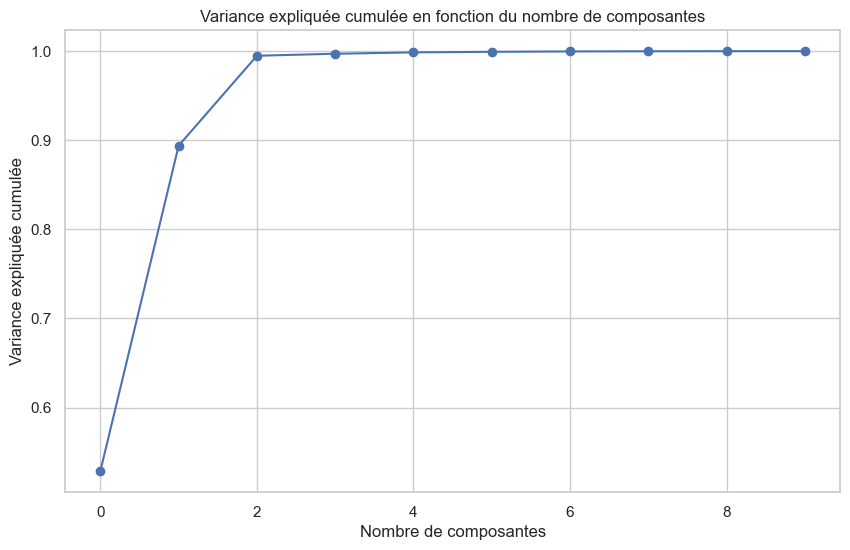

In [137]:
## Déterminer le nombre optimale de composantes

#### Initialisez PCA
pca = PCA()

#### Fit-transformez les données d'entraînement avec PCA
X_train_pca = pca.fit_transform(X_train)

#### Calculez la variance expliquée pour chaque composante
explained_variance = pca.explained_variance_ratio_

#### Tracez le graphique de la variance expliquée en fonction du nombre de composantes
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(explained_variance), marker='o', linestyle='-')
plt.xlabel('Nombre de composantes')
plt.ylabel('Variance expliquée cumulée')
plt.title('Variance expliquée cumulée en fonction du nombre de composantes')
plt.grid(True)
plt.show()

À partir de n=4, on observe que la variance expliquée cumulée se stabilise. 

In [143]:
## Pipeline (PCA, standardisation et initialisation des modèles)

svr_pca = make_pipeline(PCA(n_components=4), StandardScaler(), SVR()) #SVR
rfr_pca = make_pipeline(PCA(n_components=4), StandardScaler(), RandomForestRegressor()) #RandomForest
knn_pca = make_pipeline(PCA(n_components=4), StandardScaler(), KNeighborsRegressor()) #KNN
treedecision_pca = make_pipeline(PCA(n_components=4), StandardScaler(), DecisionTreeRegressor()) #TreeDecision

In [144]:
## Adjustement

svr_pca.fit(X_train, y)
rfr_pca.fit(X_train, y)
knn_pca.fit(X_train, y)
treedecision_pca.fit(X_train, y)

Pipeline(steps=[('pca', PCA(n_components=4)),
                ('standardscaler', StandardScaler()),
                ('decisiontreeregressor', DecisionTreeRegressor())])

In [145]:
## Prediction

Y_pred_svr_pca = svr_pca.predict(X_test)
Y_pred_rfr_pca = rfr_pca.predict(X_test)
Y_pred_knn_pca = knn_pca.predict(X_test)
Y_pred_treedecision_pca = treedecision_pca.predict(X_test)

## Assessment (Conclusion)

In [146]:
def root_mean_squared_log_error(y_true, y_pred):
    """
    Compute the root mean squared log error between y_true and y_pred.

    Parameters:
    y_true : array-like of shape (n_samples,)
        Ground truth target values.

    y_pred : array-like of shape (n_samples,)
        Estimated target values.

    Returns:
    float
        The root mean squared log error.
    """
    assert len(y_true) == len(y_pred), "Lengths of y_true and y_pred must be the same."

    squared_log_errors = (np.log1p(y_pred) - np.log1p(y_true)) ** 2
    mean_squared_log_error = np.mean(squared_log_errors)
    root_mean_squared_log_error = np.sqrt(mean_squared_log_error)

    return root_mean_squared_log_error

In [147]:
# Assessment

## Correlation between features
svr_error_corr = root_mean_squared_log_error(y_test, Y_pred_svr)
rfr_error_corr = root_mean_squared_log_error(y_test, Y_pred_rfr)
knn_error_corr = root_mean_squared_log_error(y_test, Y_pred_knn)
td_error_corr = root_mean_squared_log_error(y_test, Y_pred_tree)

## Regularization
lasso_error = root_mean_squared_log_error(y_test, Y_pred_lasso)
elasticnet_error = root_mean_squared_log_error(y_test, Y_pred_elasticnet)

## PCA
svr_error_pca = root_mean_squared_log_error(y_test, Y_pred_svr_pca)
rfr_error_pca = root_mean_squared_log_error(y_test, Y_pred_rfr_pca)
knn_error_pca = root_mean_squared_log_error(y_test, Y_pred_knn_pca)
td_error_pca = root_mean_squared_log_error(y_test, Y_pred_treedecision_pca)

In [148]:
pd.DataFrame(
    {'corr':[svr_error_corr, rfr_error_corr, knn_error_corr, td_error_corr],
     'pca':[svr_error_pca, rfr_error_pca, knn_error_pca, td_error_pca]}
    )

,corr,pca
0,0.191085,0.234355
1,0.197626,0.250555
2,0.204766,0.249524
3,0.207086,0.287924


L'erreur la plus faible obtenue est celle avec la sélection de variable sur corrélation et en utilisant le modèle SVR. 

In [149]:
print(f"Les erreurs obtenues respectivement avec Lasso et Elasticnet sont {lasso_error} et {elasticnet_error}.")

Les erreurs obtenues respectivement avec Lasso et Elasticnet sont 0.20015070977853228 et 0.20032521612045842.


In [152]:
output = pd.DataFrame({'id':submission['id'],
                       'Rings':Y_pred_svr})

In [153]:
output.to_csv('submission.csv', index=False)